In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import time
from scipy.stats import bootstrap
from scipy import linalg
from scipy import stats
import os



Code éléments finis quadratique permetant de résoudre des EDO de diffision de ce type:



$$
-\frac{d}{dx}\left(a(x)\frac{du}{dx}\right) - f(x) = 0, \quad x \in ]a, b[
$$
$$
u(a) = u(b) = 0.
$$


### Méthode de résolution
La classe fem implémente les étapes suivantes :

*  Génération des coordonnées géométriques et des degrés de liberté avec la classe tab.
*  Construction des matrices élémentaires et assemblage dans une matrice globale.
*  Application des conditions aux limites pour ajuster le système linéaire.
*  Résolution du système linéaire pour obtenir une solution discrétisée.


### Analyse de convergence

Pour évaluer la précision de la méthode, nous avons intégré une analyse de convergence dans la classe \texttt{analyse\_conv}. Cette analyse consiste à :
*  Résoudre l'équation avec un nombre croissant d'éléments .
*  Calculer l'erreur en utilisant la norme de l'espace $H^1$
*  Représenter graphiquement l'erreur en fonction du nombre d'éléments, en échelles logarithmiques.

In [ ]:
#classe pour creer les tableaux
class tab:

  def __init__(self, a, b, n):
        self.a = a  #coordonner de la tige en 1D [a, b]
        self.b = b
        self.n = n  #nombre delements

  def coor(self):
    n_geo = np.linspace(self.a, self.b, self.n + 1)


    coor = np.zeros(2*len(n_geo)-1)
    coor[1], idx = n_geo[0], 1
    for i in range(1,len(coor)):
        if i%2 == 0:
           coor[i] = n_geo[idx]
           idx += 1

        else:
            coor[i] = (n_geo[idx-1] + n_geo[idx]) /2

    return coor



  def connec(self):
    connec = pd.DataFrame(index=range(1, self.n + 1), columns=['Ddl_#1_(geo)', 'Ddl_#2_(geo)', 'Ddl_#3_(calc)'])

    #ajouter les valeurs
    connec['Ddl_#1_(geo)'] = range(1, self.n+1)
    connec['Ddl_#2_(geo)'] = range(2, self.n+2)
    connec['Ddl_#3_(calc)'] = range(self.n+2, len(self.coor())+1)
    return connec




  def coor_element(self):
    coor_geo = []
    coor_calc = []
    coor = []

    coor_n = self.coor()
    for i in range(0,len(coor_n)-2, 2):
        coor_geo.append(np.array([coor_n[i], coor_n[i+2]]))
        coor_calc.append(coor_n[i+1])
        coor.append(np.array([coor_n[i],coor_n[i+1], coor_n[i+2]]))

    coor_element = pd.DataFrame({
        'coor_geo': coor_geo,
        'coor_calc': coor_calc,
        'coor': coor
        }, index=range(1, len(coor_geo) + 1))

    return coor_element


  def tableaux(self):
    return (self.coor(),  self.connec(), self.coor_element())

  def affichage(self):

    print("\ntableau de coordonne element:\n")
    print(self.coor())

    print("\ntableau connec:\n")
    print(self.connec())

    print("\ntableau de coordonne element:\n")
    print(self.coor_element())






In [ ]:
class calcul_fem:

  def __init__(self, a, b, n, Ax, Fx): #tuple contenant le domaine et le nb elements et les fonctions du modeles

    data = tab(a, b, n)
    vecteur = data.tableaux()


    self.connec = vecteur[1]
    self.coor = vecteur[0]
    self.coor_element = vecteur[2] #tableau de coordonner des elements

    self.a = a
    self.b = b
    self.n = n
    self.dim = 2 * self.n + 1  #dimension de la matrice
    self.h =  (self.coor_element.iloc[0, 0][1] - self.coor_element.iloc[0, 0][0])

    #definition des equations du modeles
    self.Ax = Ax
    self.Fx = Fx
    self.phi_1 = lambda x: x*(x-1)/2
    self.phi_2 = lambda x: x*(x+1)/2
    self.phi_3 = lambda x: 1 - x**2
    self.df_phi_1 = lambda x: (2*x - 1) / self.h
    self.df_phi_2 = lambda x: (2*x + 1) / self.h
    self.df_phi_3 = lambda x: (-4*x) / self.h


  def transfo_geo(self, element, x):
       xk = self.coor_element.loc[element, 'coor_geo']
       return (xk[0] + xk[1] + self.h*x)/2


  def transfo_geo_inverse(self, element, x):
       xk = self.coor_element.loc[element, 'coor_geo']
       return (2*x - xk[0] - xk[1]) / self.h


  #retourne dans quel element se trouve un points x
  def find_element(self, x):
    for i, interval in enumerate(self.coor_element['coor_geo']):
        if interval[0] < x < interval[1]:
            return (i + 1, x)
    #return des nones si n<est pas dans aucun interval ou sur la frontiere dun interval


  def mat_elementaire(self, element): #le numero de l'élément
    matrice = np.zeros((self.dim, self.dim), dtype=np.float64) #matrice elementaire
    elem = self.connec.loc[element] #va chercher le dl de lelement dans la mat adres
    Ak = pd.DataFrame(columns=elem.values, index=elem.values, dtype=np.float64)

    phi = (self.df_phi_1, self.df_phi_2, self.df_phi_3)
    points, poids = np.polynomial.legendre.leggauss(3)
    for i in range(3): #ligne
      for j in range(3): #colonne
          a = np.sum(poids * ((self.Ax(self.transfo_geo(element, points))* phi[j](points) * phi[i](points) * self.h/2)))
          Ak.iloc[i, j] = float(a)
    #apres ca me reste juste a mettre les terme de la matrice Ak a la bonne place dans mat élémentaire


    # Extraction des termes non nuls avec leurs indices et colonnes
    non_null_values = Ak.stack().reset_index()
    non_null_values.columns = ['row', 'col', 'value']
    non_null_values = non_null_values[non_null_values['value'] != 0]

    #ajout des termes dans la matrice elementaire a leur bonne position selon leur degré de liberté
    for _, row in non_null_values.iterrows():
       ligne = int(row['row'])
       colonne = int(row['col'])
       val = row['value']
       matrice[ligne-1, colonne-1] = val

    return matrice



  def f(self, element):
    elem = self.connec.loc[element].values
    vecteur = np.zeros(self.dim, dtype=np.float64)

    points, poids = np.polynomial.legendre.leggauss(3)
    phi = (self.phi_1, self.phi_2, self.phi_3)

    for i in range(3):
        f = np.sum(poids * (self.h/2 * self.Fx(self.transfo_geo(element, (points))) * phi[i](points)))
        vecteur[elem[i] - 1] = f

    return vecteur


  def systeme_global(self):
    matrice_global = np.zeros((self.dim, self.dim),  dtype=np.float64)
    f = np.zeros(self.dim, dtype=np.float64)
    for i in range(1, self.n + 1): #boucle sur tous les éléments
        matrice_global = matrice_global + self.mat_elementaire(i)
        f = f + self.f(i)


    #corection du systeme pour integrer les conditions au limites
    condition_limite = np.array([self.connec.iloc[0, 0], self.connec.iloc[-1, 1]])
    matrice = np.delete(matrice_global, condition_limite - 1, axis=0)
    matrice = np.delete(matrice, condition_limite - 1, axis=1)
    f = np.delete(f, condition_limite - 1)

    return (matrice, f)




  def resolution_systeme(self):
    systeme = self.systeme_global()
    u = np.linalg.solve(systeme[0], systeme[1])

    return u

In [ ]:


class fem(calcul_fem):
    def __init__(self, a, b, n, Ax, Fx, systeme=None):
        super().__init__(a, b, n, Ax, Fx)
        if systeme is None:
          self.solution = self.resolution_systeme()
        else:
          self.solution = systeme


    def coef_u_ordre(self):
      v = self.solution
      n = self.n
      u = []
      u_geo = v[:n-1]
      u_calc = v[n-1:]

      for i in range(n-1):
        u.append(u_calc[i])
        u.append(u_geo[i])
      u.append(u_calc[-1])

      return u


    #solution numerique
    def u_delta(self,element, x):
      coef = np.concatenate(([0], self.coef_u_ordre(), [0])) #coefficient u pour la combinaison lin.

      vecteurs = []
      for i in range(self.n):
        start_index = i * (len(coef) // self.n)  # Ajuster le point de départ pour chevauchement
        end_index = start_index + 3
        vecteurs.append(coef[start_index:end_index])


      coef = vecteurs #coefficient u separer selon element
      coef_solution = coef[element-1] #les 3 coeffecients pour combin lin sur fonctions phi_1,2,3
      phi = (self.phi_1, self.phi_3, self.phi_2)
      solution = 0
      for i in range(3):
        solution += coef_solution[i] * phi[i](self.transfo_geo_inverse(element, x))

      return solution



    def du_delta(self, element, x):
      coef = np.concatenate(([0], self.coef_u_ordre(), [0])) #coefficient u pour la combinaison lin.

      vecteurs = []
      for i in range(self.n):
        start_index = i * (len(coef) // self.n)  # Ajuster le point de départ pour chevauchement
        end_index = start_index + 3
        vecteurs.append(coef[start_index:end_index])


      coef = vecteurs #coefficient u separer selon element
      coef_solution = coef[element-1] #les 3 coeffecients pour combin lin sur fonctions phi_1,2,3
      phi = (self.df_phi_1, self.df_phi_3, self.df_phi_2)
      solution = 0
      for i in range(3):
        solution += coef_solution[i] * phi[i](self.transfo_geo_inverse(element, x))  #* 2/self.h

      return solution



    def data_for_plot(self, nb_points=400, du=None):

      points_drop = [i[0] for i in self.coor_element.iloc[:, 0]]
      points = np.linspace(self.a , self.b, nb_points)
      domaine = [points[i] for i in range(len(points)) if points[i] not in points_drop]
      domaine = np.delete(domaine, [0, -1])

      #maintenant, le domaine est valide pour l'éxécution du code
      #je vais trouver les solution de u pour chaque points du domaine

      #pour la derivé ici
      if du is  None:
        solution = []
        for i in domaine:
          elem = self.find_element(i) #retourne l'Élément et chaque valeur de x
          solution.append(self.u_delta(elem[0], elem[1]))
        return (domaine, solution)

      #pour u
      solution = []
      for i in domaine:
        elem = self.find_element(i) #retourne l'Élément et chaque valeur de x
        solution.append(self.du_delta(elem[0], elem[1]))

      return (domaine, solution) #ca retourne deux liste qui contient chaque point en x et y de la solution
                                 #pret a etre affiché dans un graphique


    def norme(self):
      u_exacte = lambda x : x - x**3
      du_dx_exacte = lambda x : 1 - 3 * x**2

      norme_element = []
      for elem in range(1, self.n+1):
        a = self.coor_element.iloc[elem-1, 0][0] # Limite inférieure de l'intégration sur chaque element
        b = self.coor_element.iloc[elem-1, 0][1]  # Limite supérieure de l'intégration sur chaque element

        func_integ = lambda x : (du_dx_exacte(x) - self.du_delta(elem, x))**2 + (u_exacte(x) - self.u_delta(elem, x))**2
        result, error = quad(func_integ, a, b)

        norme_element.append(result)
      return sum(norme_element)


    def graph_solution(self):
      f = lambda x: x - x**3 #solution analytique
      x = np.linspace(0,1,400)
      y =  f(x)

      plt.figure(figsize=(7, 5))
      plt.plot(x, y, label='solution analytique')


      #affichage solution numérique
      data = self.data_for_plot()
      x = data[0]
      y = data[1]
      plt.plot(x, y, label='solution numérique')

      plt.xlabel('x')
      plt.ylabel('f(x)')
      plt.title('Solution')
      plt.legend()


      #affichage ddl
      y = self.coef_u_ordre()
      x = np.delete(self.coor, [0, -1])
      plt.scatter(x, y, color='red', label='Ddl')
      plt.legend()
      plt.show()

    def get_solution(self):
      """
      return : ((domaine et image des ddl)  et  (domaine et imagine de la solution u)  et  normes infinie de u et du)
      """
      return ((np.delete(self.coor, [0, -1]), self.coef_u_ordre()), self.data_for_plot(), self.norme())



class analyse_conv:
  def __init__(self, a, b, n, Ax, Fx, analyse_convergeance=None):

        self.solution = fem(a, b, n, Ax, Fx)
        self.solution.graph_solution()

        if analyse_convergeance is not None:
          element = [elem for elem in range(1, 40, 1)]
          erreur = []
          for elem in element:
            object_fem = fem(a, b, elem, Ax, Fx)
            erreur.append(object_fem.norme())


          plt.figure(figsize=(7, 5))
          plt.scatter(element, erreur, color='blue', marker='o', label='Erreur')
          plt.xscale('log')
          plt.yscale('log')
          plt.title('Erreur en fonction du nombre d\'éléments')
          plt.xlabel('Nombre d\'éléments')
          plt.ylabel('Erreur')
          plt.grid(True)
          plt.legend()

          plt.show()


### Nous considérons l'équation différentielle suivante :

$$
a(x) = 1 + x, \quad f(x) = x(2 - x - 3x^2),
$$

$$
-\frac{d}{dx}\left(a(x)\frac{du}{dx}\right) - f(x) = 0, \quad x \in ]0, 1[,
$$
$$
u(0) = u(1) = 0.
$$



1. **Description des paramètres de la classe**
   - $a(x) = 1 + x $ est défini dans le code par la fonction `Ax`, qui représente le coefficient de diffusion.
   - $ f(x) = x(2 - x - 3x^2) $ est défini par la fonction `Fx`, qui représente le terme source.
   - Les arguments $0$ et $1$ spécifient la frontiere du domaine
   - L'argument $4$ indique le nombre d'éléments utilisés pour discrétiser le domaine en éléments finis. Ici, le domaine \(]0, 1[\) est divisé en 4 éléments.



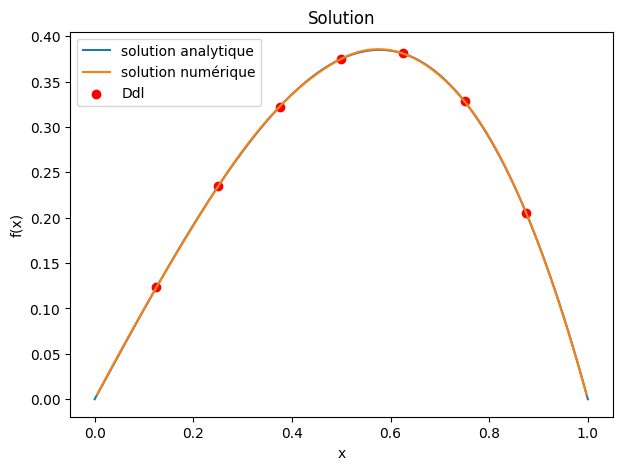

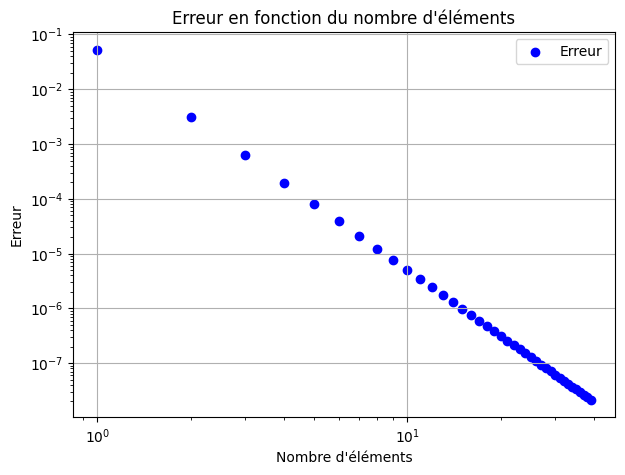

Temps d'exécution en seconde : 12.27114748954773


In [ ]:
#fonctions du modele
Ax = lambda x: 1 + x
Fx = lambda x: 9*x**2 + 6*x - 1

start_time = time.time()
test = analyse_conv(0, 1, 4, Ax, Fx,analyse_convergeance="yes")
end_time = time.time()


print(f"Temps d'exécution en seconde : {end_time - start_time}")

# Simulation de monte carlo

In [ ]:
class sim_monte_carlo:

  def __init__(self, f_coef, k, n, m, distribution):
    self.f_coef = f_coef #liste des coefficients de f
    self.f = lambda x , coef : coef[0] * np.exp(-coef[2] * (x - coef[1])**2)  #fonction f(x)
    self.k = lambda x : 1 #fonction k(x) qui est a(x) dans code mef
    self.n = n  #nombre delements mef
    self.m = m  #nombre de d/chantillonement aleatoire
    #self.distribution = a venir sera le type de distribution prob
    #self.nom_fichier = a venir sera le nom fichier creer pour save donnes


  def simulation(self, var_f):
    """
    variance pour chaque coefficient de la fonction pour la sim de monte carlo
    par defaut sont de 0 car ca veut dire que lont ne fait pas varier ce parametre
    """
    Fx = lambda x : self.f(x, self.f_coef)
    fem_officiel = fem(0, 1, self.n, self.k, Fx) #calcul mef sur la fonction
    ddl_officiel = fem_officiel.get_solution()   #j ai les domaines, ddl et solution
    solution_officiel = ddl_officiel[1][1]

    #je dois faire varier les parametres a, b, c selon une loie normal.
    a_n, b_n, c_n = np.random.normal(loc=self.f_coef[0], scale=var_f[0], size=self.m), np.random.normal(loc=self.f_coef[1], scale=var_f[1], size=self.m), np.random.normal(loc=self.f_coef[2], scale=var_f[2], size=self.m)


    #calcul fem avk nos parametre aléatoire selon loi normal
    ddl_aleatoire = []
    solution_aleatoire = []
    norme_solution_aleatoire = []
    for i in range(self.m):
       Fx = lambda x : self.f(x, [a_n[i], b_n[i], c_n[i]])
       fem_random = fem(0, 1, self.n, self.k, Fx)
       mef = fem_random.get_solution()
       ddl_aleatoire.append(mef[0][1]) #ajoute les ddl
       solution_aleatoire.append(mef[1][1]) #ajoute les solution aleatoire

    domaine_solution_aleatoire = mef[1][0]  #domaine de def des solutions aleatoires

    #tous les ddl et solution aléatoire transformer en une matrice mxn
    ddl_aleatoire = np.vstack(ddl_aleatoire)
    solution_aleatoire = np.vstack(solution_aleatoire)

    #return (domaine et imagine ddl aleatoire), (domaine et imagine solution aleatoire)         , (valeurs des ddl officiel et des solutions officiel)    et les normes L1 solutions aleatoire
    return (ddl_officiel[0][0], ddl_aleatoire), (domaine_solution_aleatoire, solution_aleatoire), (ddl_officiel[0][1], solution_officiel),  norme_solution_aleatoire





class monte_carlo(sim_monte_carlo):
    #classe simulation la variance pour la simulation mal code
    def __init__(self, f_coef, k, n, m, distribution, var=[0.01, 0.01, 0.01], nom_fichier=None):
        super().__init__(f_coef, k, n, m, distribution)
        self.data = self.simulation(var)


        self.domaine_ddl = self.data[0][0]
        self.domaine_solution = self.data[1][0]

        #ddl/solution officiel
        self.ddl_officiel = self.data[2][0]
        self.solution_officiel = self.data[2][1]

        #ddl et solution aleatoire
        self.ddl_aleatoire = self.data[0][1]
        self.solution_aleatoire = self.data[1][1]

        #calcul coefficient of variation
        mean_ddl, std_ddl = np.mean(self.data[0][1], axis=0), np.std(self.data[0][1], ddof=1, axis=0)
        cov = std_ddl / (np.sqrt(self.m) * mean_ddl) #retourne un vecteur
        print(f"le cov maximal est de : {np.max(cov)}")



    def ddl_statistic_mean(self):
      #calculé sur chaque colonne pour chaque coefficient
      mean_ddl = np.mean(self.ddl_aleatoire, axis=0)
      std_ddl = np.std(self.ddl_aleatoire, ddof=1, axis=0)

      #interval confiance
      confidence_interval_ddl = 1.96 * std_ddl / np.sqrt(self.m)
      lower_bound_ddl = mean_ddl - confidence_interval_ddl
      upper_bound_ddl = mean_ddl + confidence_interval_ddl


      #interval_bootstrap
      bootstrap_data =  bootstrap((self.ddl_aleatoire,), np.mean, axis=0, n_resamples=1000, confidence_level=0.95, method='BCa')
      interval_bas_bs = bootstrap_data.confidence_interval.low
      interval_haut_bs = bootstrap_data.confidence_interval.high


      #return valeur ddl, ...
      return mean_ddl, (lower_bound_ddl, upper_bound_ddl), (interval_bas_bs, interval_haut_bs)





    def solution_statistic(self):
      #moyenne + I.c
      mean_solution = np.mean(self.solution_aleatoire, axis=0)
      bs_mean =  bootstrap((self.solution_aleatoire,), np.mean, axis=0, n_resamples=1000, confidence_level=0.95, method='BCa')

      #std + I.C
      std_solution = np.std(self.solution_aleatoire, ddof=1, axis=0)
      bs_std = bootstrap((self.solution_aleatoire,), np.std, axis=0, n_resamples=1000, confidence_level=0.95, method='BCa')

      #quantiles
      upper_quantile = []
      lower_quantile = []
      mediane = []
      for i in range(len(mean_solution)):
        data = self.solution_aleatoire[:, i]
        upper_quantile.append(np.quantile(data, 0.975))
        lower_quantile.append(np.quantile(data, 0.025))
        mediane.append(np.quantile(data, 0.5))

      #bootstrap median
      bs_mediane = bootstrap((self.solution_aleatoire,), np.median, axis=0, n_resamples=1000, confidence_level=0.95, method='BCa')

      return (mean_solution,(bs_mean.confidence_interval.low, bs_mean.confidence_interval.high)), (std_solution,(bs_std.confidence_interval.low, bs_std.confidence_interval.high)),\
        (mediane, (bs_mediane.confidence_interval.low, bs_mediane.confidence_interval.high)), lower_quantile, upper_quantile



    def plot_solution_all(self):
      statistic = self.solution_statistic()

      plt.figure(figsize=(10, 6))
      plt.plot(self.domaine_solution, self.solution_officiel,  linestyle='-', color='red', label='solution')
      plt.plot(self.domaine_solution, statistic[2],  linestyle='-', color='blue', alpha=0.5, label='bande inferieur')
      plt.plot(self.domaine_solution, statistic[3],  linestyle='-', color='blue', alpha=0.5, label='bande supperieur')
      plt.plot(self.domaine_solution, statistic[0],  linestyle='-', color='black', alpha=0.5, label='solution moyenne')

      #plot toutes les solutions aleatoires
      for i in range(self.m):
        plt.plot(self.domaine_solution, self.solution_aleatoire[i, :],  linestyle='-', color='black', alpha=0.3)


      plt.title('solution et interval de confiance')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.legend()
      plt.grid(True)
      plt.show()


    def plot_ddl_statistic(self):
      statistic = self.ddl_statistic_mean()

      plt.figure(figsize=(10, 6))
      plt.plot(self.domaine_ddl, self.ddl_officiel,  linestyle='-', color='red', label='solution')
      plt.plot(self.domaine_ddl, statistic[0],  linestyle='-', color='black',label='solution moyenne')
      plt.plot(self.domaine_ddl, statistic[1][0],  linestyle='-', color='green',label='I.C')
      plt.plot(self.domaine_ddl, statistic[1][1],  linestyle='-', color='green',label='I.C')
      plt.plot(self.domaine_ddl, statistic[2][0],  linestyle='-', color='blue',label='I.C bootstrap')
      plt.plot(self.domaine_ddl, statistic[2][1],  linestyle='-', color='blue',label='I.C bootstrap')
      plt.title('solution et interval de confiance')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.legend()
      plt.grid(True)
      plt.show()



    def plot_ddl_hist(self):
      # Tracer des histogrammes pour chaque degré de liberté
      fig, axes = plt.subplots(20, 5, figsize=(20, 25))
      #axes = axes.flatten()

      compteur = 0
      for i in range(20):
        for j in range(5):
          axes[i, j].hist(self.ddl_aleatoire[:, compteur], bins=50, alpha=0.75, color='blue')
          axes[i, j].set_title(f'ddl_{compteur+1}')
          axes[i, j].set_xlabel('Valeur', fontsize=12)
          axes[i, j].set_ylabel('Fréquence', fontsize=12)
          compteur += 1
          if compteur == 99:
            break

      fig.tight_layout(pad=1.0)
      plt.show()



    def plot_solution(self):
      statistic = self.solution_statistic()

      #test du khi deux pour ecart type
      khi2_lower = []
      khi2_higher = []
      for i in range(self.solution_aleatoire.shape[1]):
        column_data = self.solution_aleatoire[:, i]
        sample_std = np.std(column_data, ddof=1)
        n = len(column_data)

        alpha = 0.05
        chi2_lower = stats.chi2.ppf(alpha / 2, df=n-1)
        chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=n-1)

        ci_lower = np.sqrt((n - 1) * sample_std**2 / chi2_upper)
        ci_upper = np.sqrt((n - 1) * sample_std**2 / chi2_lower)

        khi2_lower.append(ci_lower)
        khi2_higher.append(ci_upper)

      #data
      plt.figure(figsize=(10, 6))
      plt.plot(self.domaine_solution, self.solution_officiel,  linestyle='-', color='red', label='solution')
      plt.plot(self.domaine_solution, statistic[0][0],  linestyle='-', color='black', alpha=0.5, label='solution moyenne')
      plt.plot(self.domaine_solution, statistic[3],  linestyle='-', color='green', alpha=0.5, label='percentile 97.5%')
      plt.plot(self.domaine_solution, statistic[4],  linestyle='-', color='green', alpha=0.5, label='percentile 2.5%')
      plt.plot(self.domaine_solution, statistic[2][0],  linestyle='-', color='purple', alpha=0.2, label='mediane')
      plt.title('resultats simulation')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.legend()
      plt.grid(True)
      plt.show()


      #affichage des statistique
      fig, axs = plt.subplots(1, 3, figsize=(14, 7))

      #moyenne
      axs[0].plot(self.domaine_solution, statistic[0][0],  linestyle='-', color='red', alpha=0.5, label='solution moyenne')
      axs[0].plot(self.domaine_solution, statistic[0][1][0],  linestyle='-', color='blue', alpha=0.5, label='lower bound')
      axs[0].plot(self.domaine_solution, statistic[0][1][1],  linestyle='-', color='blue', alpha=0.5, label='upper bound')
      axs[0].set_title('moyenne et I-C a 95%')

      #variance
      axs[1].plot(self.domaine_solution, statistic[1][0],  linestyle='-', color='red', alpha=0.5, label='ecart type')
      axs[1].plot(self.domaine_solution, statistic[1][1][0],  linestyle='-', color='blue', alpha=0.5, label='lower bound')
      axs[1].plot(self.domaine_solution, statistic[1][1][1],  linestyle='-', color='blue', alpha=0.5, label='upper bound')
      #axs[1].plot(self.domaine_solution, khi2_lower,  linestyle='-', color='green', alpha=0.5, label='I.C parametric')
      #axs[1].plot(self.domaine_solution, khi2_higher,  linestyle='-', color='green', alpha=0.5, label='I.C parametric')
      axs[1].set_title('ecart-type et I-C a 95%')

      #mediane
      axs[2].plot(self.domaine_solution, statistic[2][0],  linestyle='-', color='red', alpha=0.5, label='mediane et I-C a 95%')
      axs[2].plot(self.domaine_solution, statistic[2][1][0],  linestyle='-', color='blue', alpha=0.5, label='lower bound')
      axs[2].plot(self.domaine_solution, statistic[2][1][1],  linestyle='-', color='blue', alpha=0.5, label='upper bound')
      axs[2].set_title('Mediane et I-C a 95%')


      # Ajouter des légendes
      for ax in axs.flat:
        ax.legend()
        ax.grid(True)

      plt.tight_layout()
      plt.show()













le cov maximal est de : 0.025042545166006323


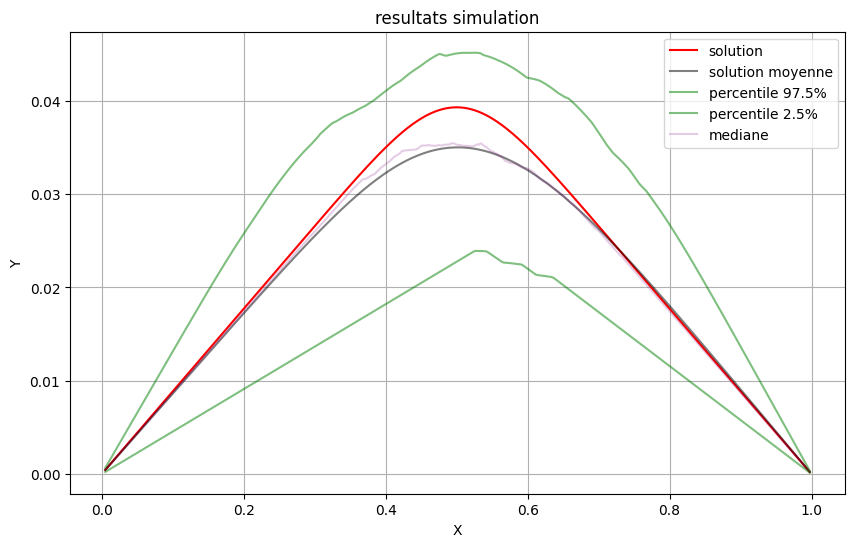

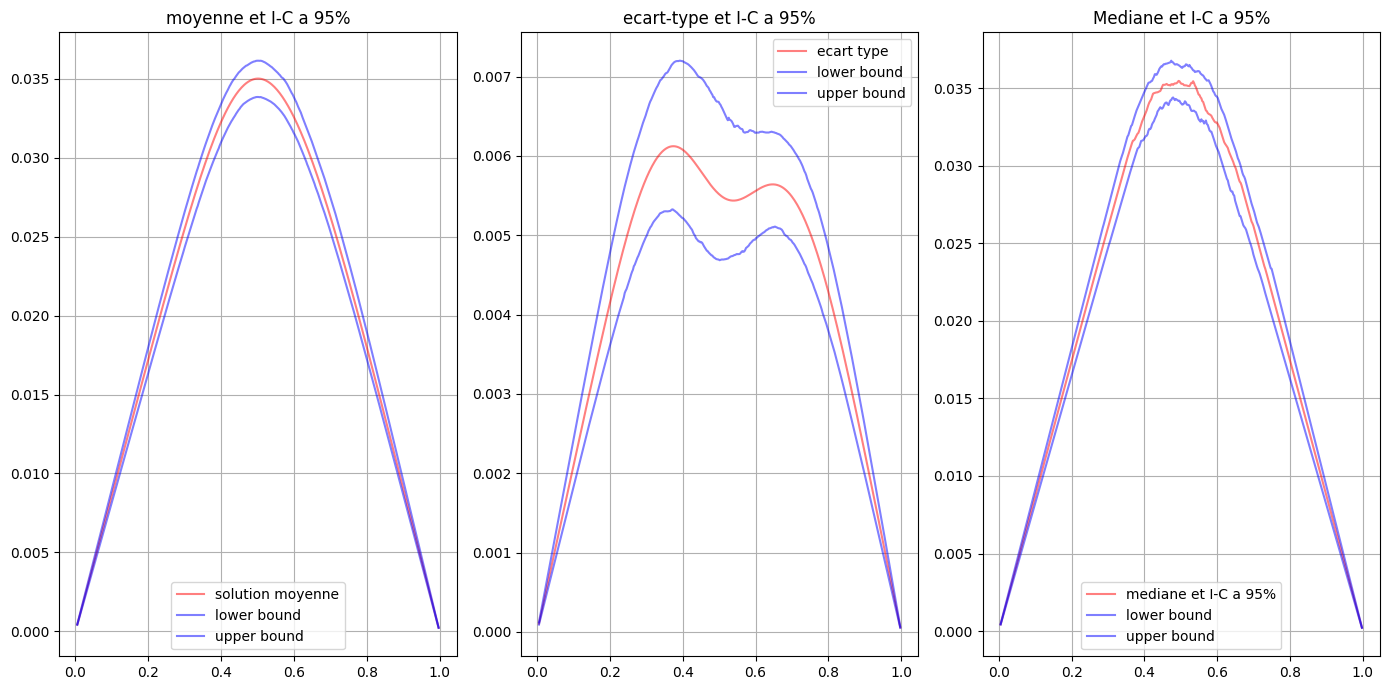

In [ ]:
test = monte_carlo([1, 0.5, 100], 1, 50, 100, "normal", [0.1, 0.1 , 10])
test.plot_solution()





le cov maximal est de : 0.37829283328583113


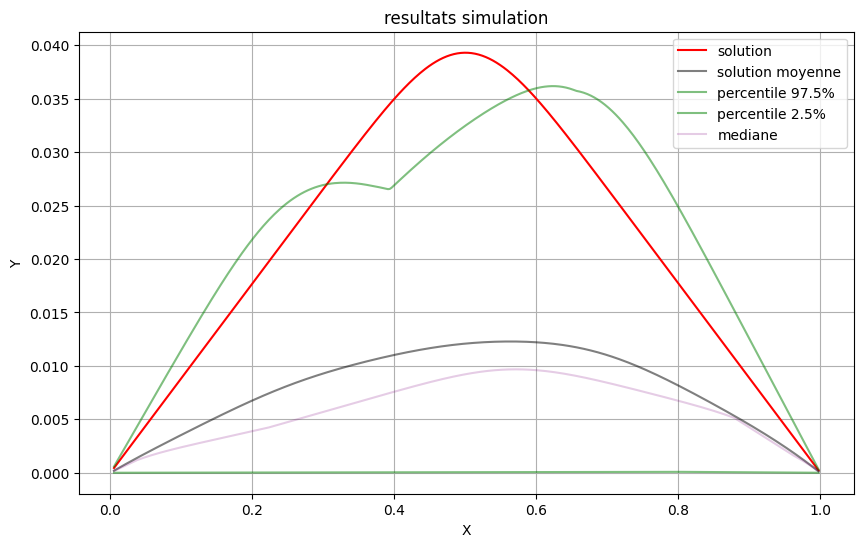

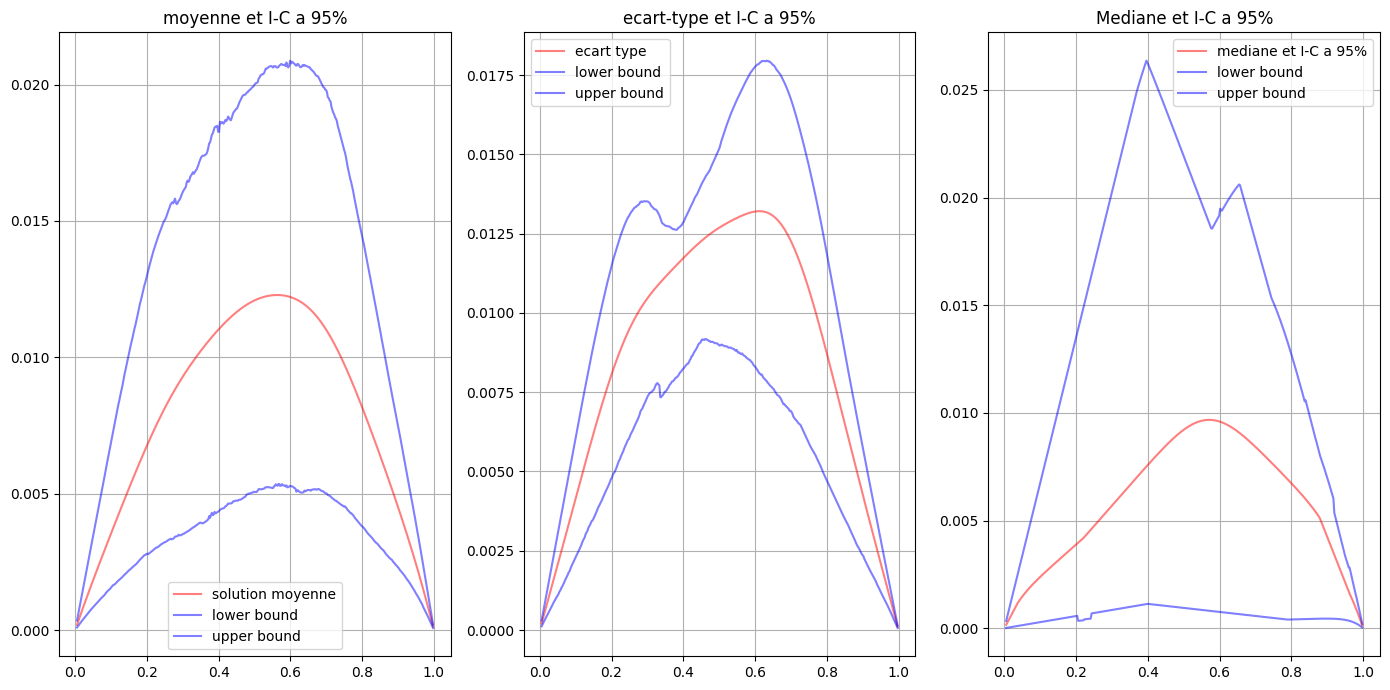

In [ ]:
test = monte_carlo([1, 0.5, 100], 1, 50, 10, "normal", [0.5, 0.5 , 10])
test.plot_solution()

In [ ]:
def bootstrap_t(data, func, n_resamples=1000, alpha=0.05):
    n = len(data)
    original_stat = func(data)
    studentized_stats = np.zeros(n_resamples)

    # Calculer l'erreur standard de l'échantillon original
    original_std = np.std(data, ddof=1) / np.sqrt(n)

    for i in range(n_resamples):
        # Générer un échantillon bootstrap
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        # Calculer la statistique de l'échantillon bootstrap
        bootstrap_stat = np.mean(bootstrap_sample)
        # Calculer l'erreur standard bootstrap
        bootstrap_std = np.std(bootstrap_sample) / np.sqrt(n)  #formule analytique plug-in
        # Calculer la statistique studentisée
        studentized_stats[i] = (bootstrap_stat - original_stat) / bootstrap_std


    # Calculer les quantiles pour l'intervalle de confiance
    lower_quantile = np.percentile(studentized_stats, 100 * alpha / 2)
    upper_quantile = np.percentile(studentized_stats, 100 * (1 - alpha / 2))
    ci_lower = original_stat - upper_quantile * original_std
    ci_upper = original_stat - lower_quantile * original_std

    return ci_lower, ci_upper


In [ ]:
from scipy.stats import bootstrap, t
import scipy.stats as stats


sample = np.random.normal(0, 1, 10000)

def parametre(data):
  return np.exp(np.mean(data))

bootstrap_data = bootstrap((sample,), parametre, n_resamples=1000,  confidence_level=0.95,  method='percentile')
bootstrap_hist = bootstrap_data.bootstrap_distribution
#SEboot = bootstrap_data.standard_error
SEboot = np.std(sample, ddof=1)/ np.sqrt(10)

# Extraire l'intervalle de confiance
ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high

#l'interval de confiance classic selon hypothese ne normalite et SEboot
#ci_high_normal = parametre(sample) + stats.norm.ppf(0.975)*SEboot
#ci_low_normal = parametre(sample) + stats.norm.ppf(0.025)*SEboot
n = len(sample)
t_critique = stats.t.ppf((1 + 0.95) / 2, n - 1)
ci_low_normal, ci_high_normal = parametre(sample) - t_critique*SEboot, parametre(sample) + t_critique*SEboot


ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, parametre)




# Transformation logarithmique des données bootstrap
log_bootstrap_hist = np.log(bootstrap_hist)
ci_low_log, ci_high_log, ci_low_normal_log, ci_high_normal_log = np.log(ci_low), np.log(ci_high), np.log(ci_low_normal), np.log(ci_high_normal)
ci_low_bootstrap_t_log, ci_high_bootstrap_t_log = np.log(ci_low_bootstrap_t), np.log(ci_high_bootstrap_t)



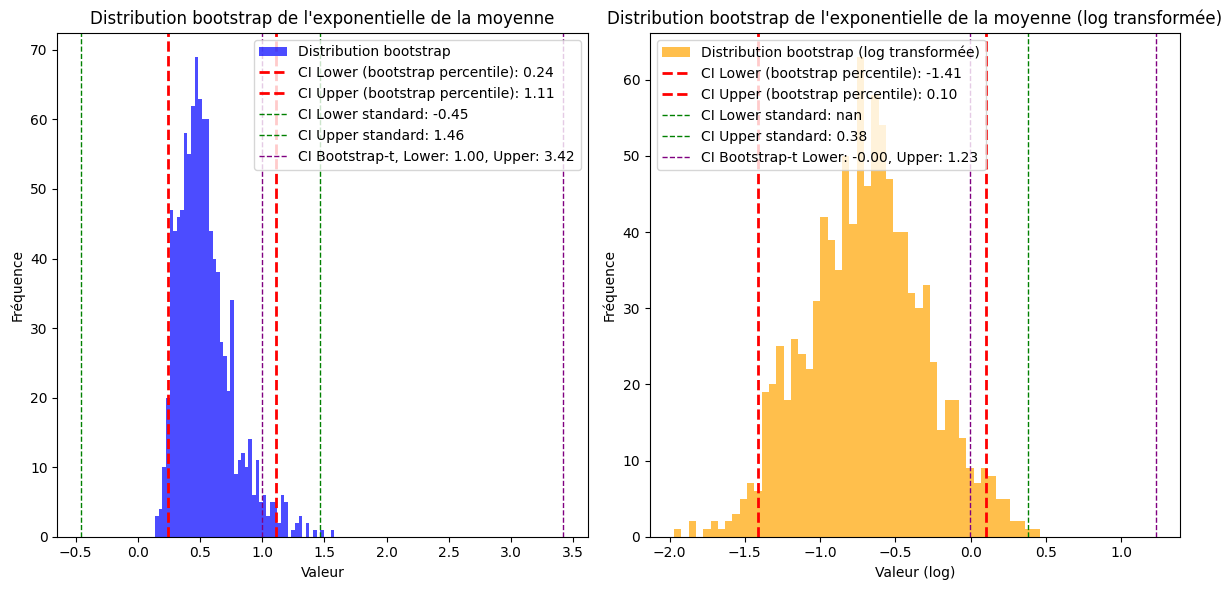

In [ ]:
plt.figure(figsize=(12, 6))

# Premier graphique
plt.subplot(1, 2, 1)
plt.hist(bootstrap_hist, bins=50, alpha=0.7, color='blue', label='Distribution bootstrap')
plt.axvline(ci_low, color='red', linestyle='dashed', linewidth=2, label=f'CI Lower (bootstrap percentile): {ci_low:.2f}')
plt.axvline(ci_high, color='red', linestyle='dashed', linewidth=2, label=f'CI Upper (bootstrap percentile): {ci_high:.2f}')
plt.axvline(ci_low_normal, color='green', linestyle='dashed', linewidth=1, label=f'CI Lower standard: {ci_low_normal:.2f}')
plt.axvline(ci_high_normal, color='green', linestyle='dashed', linewidth=1, label=f'CI Upper standard: {ci_high_normal:.2f}')
plt.axvline(ci_low_bootstrap_t, color='purple', linestyle='--', linewidth=1, label=f'CI Bootstrap-t, Lower: {ci_low_bootstrap_t:.2f}, Upper: {ci_high_bootstrap_t:.2f}')
plt.axvline(ci_high_bootstrap_t, color='purple', linestyle='--', linewidth=1)
plt.title('Distribution bootstrap de l\'exponentielle de la moyenne')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()

# Deuxième graphique
plt.subplot(1, 2, 2)
plt.hist(log_bootstrap_hist, bins=50, alpha=0.7, color='orange', label='Distribution bootstrap (log transformée)')
plt.axvline(ci_low_log, color='red', linestyle='dashed', linewidth=2, label=f'CI Lower (bootstrap percentile): {ci_low_log:.2f}')
plt.axvline(ci_high_log, color='red', linestyle='dashed', linewidth=2, label=f'CI Upper (bootstrap percentile): {ci_high_log:.2f}')
plt.axvline(ci_low_normal_log, color='green', linestyle='--', linewidth=1, label=f'CI Lower standard: {ci_low_normal_log:.2f}')
plt.axvline(ci_high_normal_log, color='green', linestyle='--', linewidth=1, label=f'CI Upper standard: {ci_high_normal_log:.2f}')
plt.axvline(ci_low_bootstrap_t_log, color='purple', linestyle='--', linewidth=1, label=f'CI Bootstrap-t Lower: {ci_low_bootstrap_t_log:.2f}, Upper: {ci_high_bootstrap_t_log:.2f}')
plt.axvline(ci_high_bootstrap_t_log, color='purple', linestyle='--', linewidth=1)
plt.title('Distribution bootstrap de l\'exponentielle de la moyenne (log transformée)')
plt.xlabel('Valeur (log)')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

simulation exp(mean)




In [ ]:
#temps de calcul
start_time = time.time()


df = pd.DataFrame(0, index=['t-Student', 'percentile (non paramétric)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])
moyenne = 1
n = 10 #le nombre d'échantillon
simulation = 10000 #le nombre de simulation

def parametre(data):
  return np.exp(np.mean(data))


for _ in range(simulation):

  sample = np.random.normal(0, 1, n)
  bootstrap_data = bootstrap((sample,), parametre, n_resamples=1000,  confidence_level=0.95,  method='percentile')
  bootstrap_hist = bootstrap_data.bootstrap_distribution

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high

  #l'interval de confiance classic selon hypothese ne normalite et SEboot
  #SEboot = bootstrap_data.standard_error
  SEboot = np.std(sample, ddof=1)/ np.sqrt(n)
  #ci_high_normal = parametre(sample) + stats.norm.ppf(0.975)*SEboot
  #ci_low_normal = parametre(sample) + stats.norm.ppf(0.025)*SEboot
  alpha = 0.05
  t_critical = stats.t.ppf(1 - alpha/2, df=n-1)  # Quantile t pour 95% IC
  ci_high_normal = parametre(sample) + t_critical * SEboot
  ci_low_normal = parametre(sample) - t_critical * SEboot

  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, parametre)

  #test percentile
  if (moyenne < ci_low):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high):
    df.iloc[1, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[2, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[2, 1] += 1

  #test standart normal
  if (moyenne < ci_low_normal):
    df.iloc[0, 0] += 1
  if (moyenne > ci_high_normal):
    df.iloc[0, 1] += 1



df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()

Le temps d'exécution du code est de 0.299335 heures


,% miss left,% miss right,% total
t-Student,5.65,0.60,6.25
percentile (non paramétric),5.03,4.93,9.96
bootstrap-t (non paramétrique),97.80,0.00,97.80


Simulation moyenne loi normal

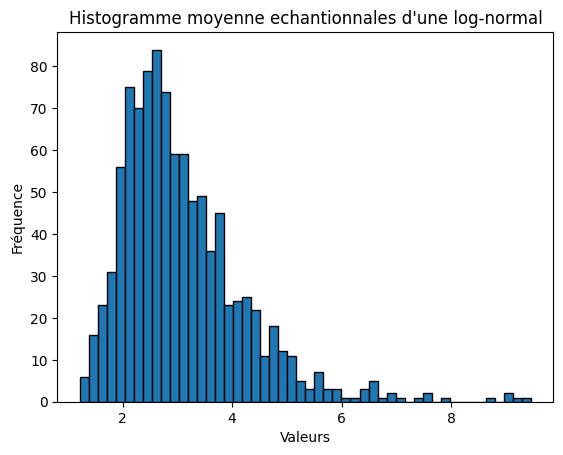

Le temps d'exécution du code est de 0.001084 heures


,% miss left,% miss right,% total
percentile (non paramétric),1.9,12.2,14.1
bootstrap-t (non paramétrique),0.0,100.0,100.0


In [ ]:
mu = 0
sigma = 3/2
n = 50 #le nombre d'échantillon
simulation = 1000 #le nombre de simulation


start_time = time.time()

moyenne = np.exp(mu + sigma**2/2)
df = pd.DataFrame(0, index=['percentile (non paramétric)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])

vecteur_moyenne = []
for _ in range(simulation):

  sample = np.random.lognormal(mu, sigma, n)
  vecteur_moyenne.append(np.mean(sample))#utiliser pour tracer histogramme

  bootstrap_data = bootstrap((sample,), np.mean, n_resamples=1000,  confidence_level=0.95)

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high



  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, np.mean,1000)

  #test percentile
  if (moyenne < ci_low):
    df.iloc[0, 0] += 1
  if (moyenne > ci_high):
    df.iloc[0, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[1, 1] += 1



#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Histogramme moyenne echantionnales d'une log-normal")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()


In [ ]:
sim = df
print('1k sim avec 10k resemple')
sim.head()

1k sim avec 10k resemple


,% miss left,% miss right,% total
standard normal,4.2,4.9,9.1
percentile (non paramétric),4.7,5.7,10.4
bootstrap-t (non paramétrique),1.7,1.9,3.6


simulation lognormal

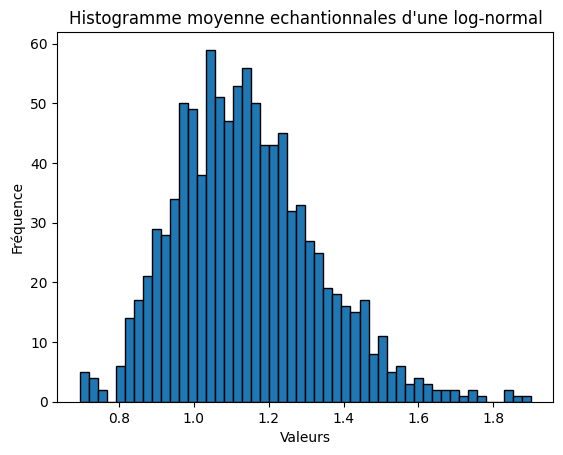

Le temps d'exécution du code est de 0.001143 heures


,% miss left,% miss right,% total
standard normal,0.0,0.0,0.0
percentile (non paramétric),3.9,7.7,11.6
bootstrap-t (non paramétrique),0.0,0.0,0.0


In [ ]:
'''
!!!!!!!!!imp!!!!!!!!!

dans le livre ca dit que lorsque la population est asymetrique, il est preferable d'utiliser bootstrap-t
'''

mu = 0
sigma = 1/2
n = 10 #le nombre d'échantillon
simulation = 1000 #le nombre de simulation


start_time = time.time()

moyenne = np.exp(mu + sigma**2/2)
df = pd.DataFrame(0, index=['standard normal', 'percentile (non paramétric)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])

vecteur_moyenne = []
for _ in range(simulation):

  sample = np.random.lognormal(mu, sigma, n)
  vecteur_moyenne.append(np.mean(sample))#utiliser pour tracer histogramme

  bootstrap_data = bootstrap((sample,), np.mean, n_resamples=1000,  confidence_level=0.95)

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high



  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, np.mean,1000)

  #test percentile
  if (moyenne < ci_low):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high):
    df.iloc[1, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[2, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[2, 1] += 1



#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Histogramme moyenne echantionnales d'une log-normal")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()

1k simulation avec 10k sampling bootstrap


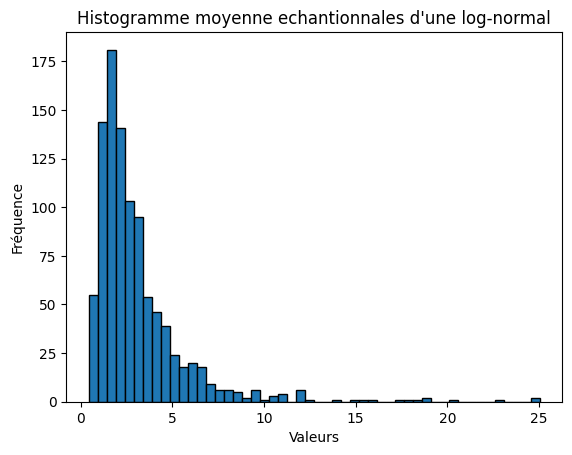

,% miss left,% miss right,% total
standard normal,0.0,0.0,0.0
percentile (non paramétric),0.7,25.3,26.0
bootstrap-t (non paramétrique),0.0,13.3,13.3


In [ ]:
print('1k simulation avec 10k sampling bootstrap')
#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Histogramme moyenne echantionnales d'une log-normal")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()
df.head()

1k simulation avec 1k sampling bootstrap


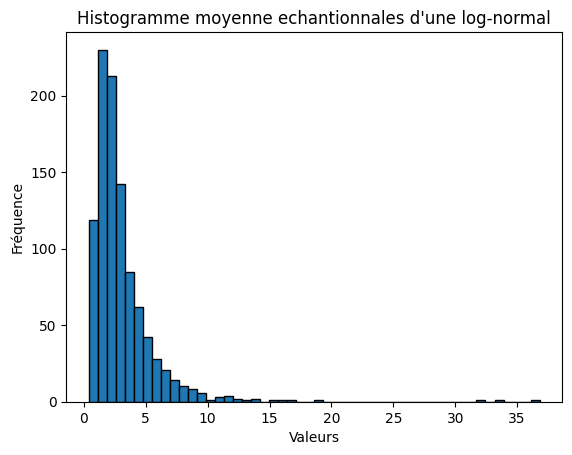

,% miss left,% miss right,% total
standard normal,0.0,0.0,0.0
percentile (non paramétric),1.2,26.2,27.4
bootstrap-t (non paramétrique),0.2,15.5,15.7


In [ ]:
print('1k simulation avec 1k sampling bootstrap')
#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Histogramme moyenne echantionnales d'une log-normal")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()
df.head()

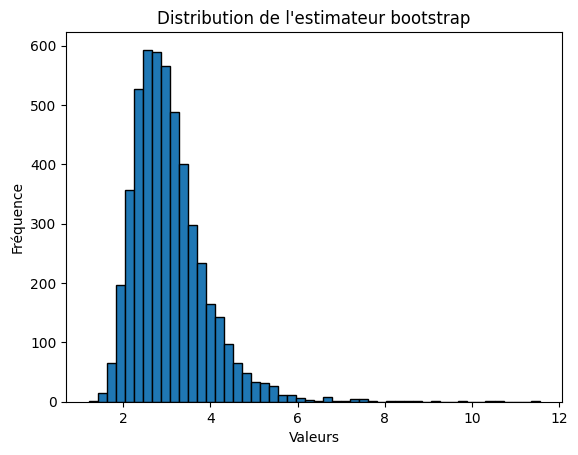

Le temps d'exécution du code est de 0.647093 heures


,% miss left,% miss right,% total
percentile (non paramétric),2.28,9.30,11.58
bootstrap-t (non paramétrique),1.12,7.22,8.34


In [ ]:
mu = 0
sigma = 3/2
n = 100 #le nombre d'échantillon
simulation = 5000 #le nombre de simulation


start_time = time.time()

moyenne = np.exp(mu + sigma**2/2)
df = pd.DataFrame(0, index=['percentile (non paramétric)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])

vecteur_moyenne = []
for _ in range(simulation):

  sample = np.random.lognormal(mu, sigma, n)
  vecteur_moyenne.append(np.mean(sample))#utiliser pour tracer histogramme

  bootstrap_data = bootstrap((sample,), np.mean, n_resamples=5000,  confidence_level=0.95)

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high



  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, np.mean,5000)

  #test percentile
  if (moyenne < ci_low):
    df.iloc[0, 0] += 1
  if (moyenne > ci_high):
    df.iloc[0, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[1, 1] += 1



#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Distribution de l'estimateur bootstrap")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()

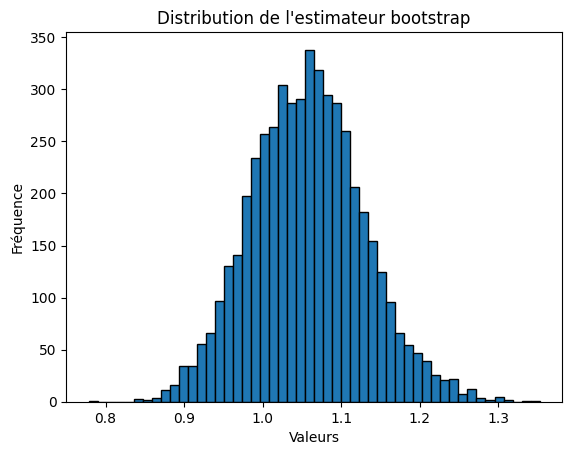

Le temps d'exécution du code est de 0.631927 heures


,% miss left,% miss right,% total
student (paramétrique),1.38,4.46,5.84
percentile (non paramétrique),3.00,4.42,7.42
bootstrap-t (non paramétrique),2.08,3.04,5.12


In [ ]:

mu = 0
sigma = 1/3
n = 25 #le nombre d'échantillon
simulation = 5000 #le nombre de simulation


start_time = time.time()

moyenne = np.exp(mu + sigma**2/2)
df = pd.DataFrame(0, index=['student (paramétrique)', 'percentile (non paramétrique)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])

vecteur_moyenne = []
for _ in range(simulation):

  sample = np.random.lognormal(mu, sigma, n)
  vecteur_moyenne.append(np.mean(sample))#utiliser pour tracer histogramme

  bootstrap_data = bootstrap((sample,), np.mean, n_resamples=5000,  confidence_level=0.95)

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high

  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, np.mean,5000)

  #test de student
  SEboot = np.std(sample, ddof=1)/ np.sqrt(n)
  alpha = 0.05
  t_critical = stats.t.ppf(1 - alpha/2, df=n-1)  # Quantile t pour 95% IC
  ci_high_normal = np.mean(sample) + t_critical * SEboot
  ci_low_normal = np.mean(sample) - t_critical * SEboot

     #test t-student
  if (moyenne < ci_low_normal):
    df.iloc[0, 0] += 1
  if (moyenne > ci_high_normal):
    df.iloc[0, 1] += 1


  #test percentile
  if (moyenne < ci_low):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high):
    df.iloc[1, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[2, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[2, 1] += 1



#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Distribution de l'estimateur bootstrap")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()

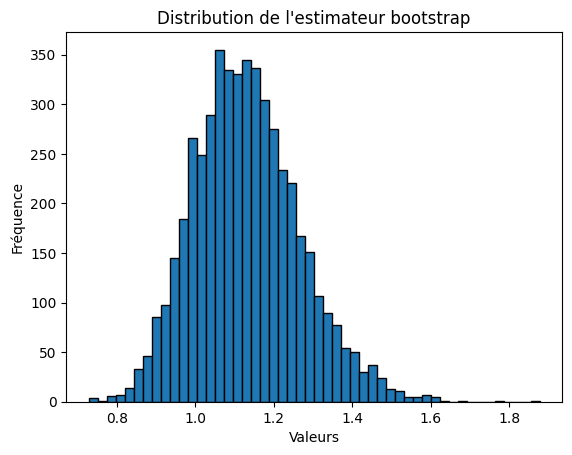

Le temps d'exécution du code est de 0.354725 heures


,% miss left,% miss right,% total
student (paramétrique),0.74,6.58,7.32
percentile (non paramétrique),3.20,6.12,9.32
bootstrap-t (non paramétrique),1.60,3.86,5.46


In [ ]:
mu = 0
sigma = 1/2
n = 20 #le nombre d'échantillon
simulation = 5000 #le nombre de simulation


start_time = time.time()

moyenne = np.exp(mu + sigma**2/2)
df = pd.DataFrame(0, index=['student (paramétrique)', 'percentile (non paramétrique)', 'bootstrap-t (non paramétrique)'], columns=['% miss left', '% miss right'])

vecteur_moyenne = []
for _ in range(simulation):

  sample = np.random.lognormal(mu, sigma, n)
  vecteur_moyenne.append(np.mean(sample))#utiliser pour tracer histogramme

  bootstrap_data = bootstrap((sample,), np.mean, n_resamples=3000,  confidence_level=0.95)

  # Extraire l'intervalle de confiance
  ci_low, ci_high = bootstrap_data.confidence_interval.low, bootstrap_data.confidence_interval.high

  #bootstrap-t
  ci_low_bootstrap_t, ci_high_bootstrap_t = bootstrap_t(sample, np.mean,3000)

  #test de student
  SEboot = np.std(sample, ddof=1)/ np.sqrt(n)
  alpha = 0.05
  t_critical = stats.t.ppf(1 - alpha/2, df=n-1)  # Quantile t pour 95% IC
  ci_high_normal = np.mean(sample) + t_critical * SEboot
  ci_low_normal = np.mean(sample) - t_critical * SEboot

     #test t-student
  if (moyenne < ci_low_normal):
    df.iloc[0, 0] += 1
  if (moyenne > ci_high_normal):
    df.iloc[0, 1] += 1


  #test percentile
  if (moyenne < ci_low):
    df.iloc[1, 0] += 1
  if (moyenne > ci_high):
    df.iloc[1, 1] += 1

  #test bootstrap-t
  if (moyenne < ci_low_bootstrap_t):
    df.iloc[2, 0] += 1
  if (moyenne > ci_high_bootstrap_t):
    df.iloc[2, 1] += 1



#afficher graphique ddistribution stats
plt.hist(vecteur_moyenne, bins=50, edgecolor='black')
plt.title("Distribution de l'estimateur bootstrap")
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()

df = (df/simulation) * 100
df['% total'] = df.sum(axis=1)




end_time = time.time()  # Arrêter le chronomètre
execution_time_seconds = end_time - start_time  # Calculer le temps d'exécution en secondes
execution_time_hours = execution_time_seconds / 3600
print(f"Le temps d'exécution du code est de {execution_time_hours:.6f} heures")


df.head()